![](https://www.gstatic.com/devrel-devsite/vb298438d35e34dff3f97c40f057464525beed8d6a3ecb339c274e51019bd45e6/tensorflow/images/lockup.svg)

# TensorFlow 2.0

**Reference Documentation**: https://www.tensorflow.org/beta/guide/effective_tf2

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/leriomaggio/tf2-workshop/blob/master/3-tensorflow-2.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/leriomaggio/tf2-workshop/blob/master/3-tensorflow-2.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

In [4]:
import tensorflow as tf

tf.__version__

'2.0.0-beta1'

### Note

If you don't have **TensorFlow** installed, or if you are using `tf` version 1, please execute the following command in a notebook cell (note the exclamation mark at the beginning):

    !pip install tensorflow-gpu==2.0.0-beta1
    
    

In [5]:
tf.executing_eagerly() #Check that it's executing eagerly

True

In [6]:
tf.test.is_gpu_available()

False

In [7]:
a = tf.constant(1) #Let's create our first Tensor
a

<tf.Tensor: id=0, shape=(), dtype=int32, numpy=1>

# TensorFlow 2 ❤️ Numpy

TF and Numpy can use their own functions with mixed arguments (Tensors or arrays), giving coherent results.

In [8]:
import numpy as np

In [9]:
b = np.array(3) #create an arrat
b

array(3)

In [10]:
c = tf.add(a, b) #array + Tensor = Tensor
c

<tf.Tensor: id=3, shape=(), dtype=int32, numpy=4>

In [11]:
c = a + b #also like this
c

<tf.Tensor: id=6, shape=(), dtype=int32, numpy=4>

In [12]:
d = np.add(a,b)  #but if we use a numpy op it becomes an array
d

4

In [13]:
c.numpy() #we can take the numpy of a tensor like this

4

# tf.Tensor? tf.Variable!

In [14]:
v = tf.Variable(tf.ones([2, 2])) #when you want to create a stateful object to be manipulated, create a Variable
v

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [15]:
v = tf.Variable([[1.,1.],[1.,1.]])
v

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [16]:
with tf.device("/device:CPU:0"):  #you can place it on selected devices. by default, it goes on the fastest
    faster_v = tf.Variable([[1.,1.],[1.,1.]])
faster_v.device, v.device

('/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:CPU:0')

In [17]:
with tf.device("/device:CPU:0"):
    slower_v = tf.Variable([[1.,1.],[1.,1.]])
slower_v.device, v.device

('/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:CPU:0')

Many TensorFlow operations are accelerated using the GPU for computation. 

Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation copying the tensor between CPU and GPU memory,

if necessary. Tensors produced by an operation are typically backed by the memory of the device on which the operation executed, for example:

In [18]:
(faster_v + slower_v).device

'/job:localhost/replica:0/task:0/device:CPU:0'

```python
#Put it at the beginning! Useful for avoiding TF from taking all GPU memory from the beginning
tf.config.gpu.set_per_process_memory_growth(False)
tf.debugging.set_log_device_placement(True)
```

In [19]:
v + 1 #Tensor!

<tf.Tensor: id=49, shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [20]:
u = v + 1
u

<tf.Tensor: id=53, shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

#### Variable Methods

Use Variable methods to keep a variable a variable. That's what you will use for optimization (that is internally used by optimizers)

In [21]:
v.assign_add(tf.ones([2,2]))

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [22]:
v.trainable

True

The idea is to use Variables for stuff that we want to store and, probably, optimize.
Tensors are passed around as values to be manipulated with Variables.
Tensors are immutable! This comes from TF 1.0.

# Using GradientTape to store gradients
TensorFlow provides the tf.GradientTape API for automatic differentiation - computing the gradient of a computation with respect to its input variables. Tensorflow "records" all operations executed inside the context of a tf.GradientTape onto a "tape"

In [23]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
    t.watch(x)  #only needed if the variable is NOT a tf.Variable
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# Derivative of z (scalar) with respect to the original input tensor x (matrix)
dz_dx = t.gradient(z, x)
dz_dx

<tf.Tensor: id=74, shape=(2, 2), dtype=float32, numpy=
array([[8., 8.],
       [8., 8.]], dtype=float32)>

In [24]:
dz_dy = t.gradient(z, y)  #can't call it a second time by default. helps preventing errors.

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

By default, the resources held by a `GradientTape` are released as soon as `GradientTape.gradient()` method is called.

To compute multiple gradients over the same computation, create a persistent gradient tape. 
This allows multiple calls to the `gradient()` method, as resources are released when the tape object is garbage collected.

In [25]:
x = tf.ones((2, 2))

with tf.GradientTape(persistent = True) as t:
    t.watch(x)  #only needed if the variable is NOT a tf.Variable
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# Derivative of z (scalar) with respect to y (scalar)
dz_dy = t.gradient(z, y)

dz_dx = t.gradient(z, x)

dz_dz = t.gradient(z, z)

dz_dy, dz_dx, dz_dz

(<tf.Tensor: id=85, shape=(), dtype=float32, numpy=8.0>,
 <tf.Tensor: id=97, shape=(2, 2), dtype=float32, numpy=
 array([[8., 8.],
        [8., 8.]], dtype=float32)>,
 <tf.Tensor: id=98, shape=(), dtype=float32, numpy=1.0>)

### Higher Order Gradients

In [26]:
#Higher Order Gradients!

x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        y = x * x * x
        # Compute the gradient inside the 't' context manager
        # which means the gradient computation is differentiable as well.
        dy_dx = t2.gradient(y, x)

    d2y_dx2 = t.gradient(dy_dx, x)

d2y_dx2, dy_dx

(<tf.Tensor: id=141, shape=(), dtype=float32, numpy=6.0>,
 <tf.Tensor: id=126, shape=(), dtype=float32, numpy=3.0>)

# Now we can train a simple model!
We'll create a linear, one input one output model.

In [27]:
w = tf.Variable(2.0)  #a linear model is a very very simple neural network with one neuron and no non-linearity
b = tf.Variable(0.0)

In [28]:
def forward(x):
    return w*x + b

In [29]:
forward(1.)

<tf.Tensor: id=162, shape=(), dtype=float32, numpy=2.0>

In [30]:
def loss(predicted_y, desired_y):  #define a loss with tf operations
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

In [31]:
TRUE_W = 3.0  #generate training data. it's a wavy-line
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])*0.2
outputs = inputs * TRUE_W + TRUE_b + noise + 2.*np.sin(inputs*3.14)

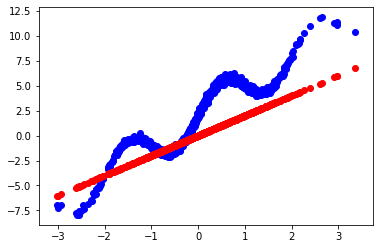

Current loss: 
6.9774814


In [32]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, forward(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(forward(inputs), outputs).numpy())


In [33]:
def train(inputs, outputs, learning_rate):  #manual training step
    with tf.GradientTape() as t:
        current_loss = loss(forward(inputs), outputs)
    dw, db = t.gradient(current_loss, [w, b])
    w.assign_sub(learning_rate * dw)
    b.assign_sub(learning_rate * db)

In [34]:
epochs = range(10)
for epoch in epochs:

    current_loss = loss(forward(inputs), outputs)

    train(inputs, outputs, learning_rate=0.1)
    print('Epoch {}: loss={}'.format(epoch, current_loss))


Epoch 0: loss=6.977481365203857
Epoch 1: loss=5.168135643005371
Epoch 2: loss=4.016936302185059
Epoch 3: loss=3.284484624862671
Epoch 4: loss=2.8184614181518555
Epoch 5: loss=2.521953821182251
Epoch 6: loss=2.333300828933716
Epoch 7: loss=2.2132699489593506
Epoch 8: loss=2.1369004249572754
Epoch 9: loss=2.0883100032806396


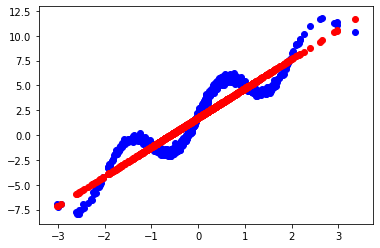

Current loss: 
2.0573945


In [35]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, forward(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(forward(inputs), outputs).numpy())


# Let's build neural networks: tf.Keras!
We have three main ways of building a model with tf.Keras: Sequential, Functional, and subclassing.
(by the way, Keras and tf.Keras are not completely the same things)

In [36]:
from tensorflow.keras import layers

In [37]:
model = tf.keras.Sequential([
# Adds a densely-connected layer with 64 units to the model:
layers.Dense(64, activation='relu', input_shape=(1,)),
# Add another:
layers.Dense(64, activation='relu'),
# Add a softmax layer with 10 output units:
layers.Dense(1, activation='linear')])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mse'])

In [38]:
model.fit(x = inputs, y = outputs, epochs = 20, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 0s 300us/sample - loss: 13.3380 - mse: 13.3380 - val_loss: 11.3195 - val_mse: 11.3195
Epoch 2/20
900/900 [==============================] - 0s 67us/sample - loss: 9.4382 - mse: 9.4382 - val_loss: 6.5771 - val_mse: 6.5771
Epoch 3/20
900/900 [==============================] - 0s 99us/sample - loss: 4.6339 - mse: 4.6339 - val_loss: 2.1669 - val_mse: 2.1669
Epoch 4/20
900/900 [==============================] - 0s 97us/sample - loss: 1.8540 - mse: 1.8540 - val_loss: 1.7371 - val_mse: 1.7371
Epoch 5/20
900/900 [==============================] - 0s 99us/sample - loss: 1.5641 - mse: 1.5641 - val_loss: 1.5299 - val_mse: 1.5299
Epoch 6/20
900/900 [==============================] - 0s 133us/sample - loss: 1.4675 - mse: 1.4675 - val_loss: 1.4332 - val_mse: 1.4332
Epoch 7/20
900/900 [==============================] - 0s 60us/sample - loss: 1.3770 - mse: 1.3770 - val_loss: 1.3394 - val_mse: 1.3394
Epo

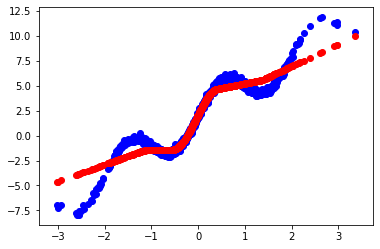

Current loss: 
0.6959393


In [39]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(tf.expand_dims(inputs,1))[:,0], c='r')
plt.show()

print('Current loss: '),
print(loss(model(tf.expand_dims(inputs,1))[:,0], outputs).numpy())


In [40]:
#Functional
#With Functional API, you can treat layers like functions and manipulate the intermediate outputs.
#It gives more flexibility, e.g. I can easily add up two outputs from different layers.
input_x = layers.Input(shape = [1])
x = layers.Dense(64, activation = "relu")(input_x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dense(1, activation = "linear")(x)

model = tf.keras.Model(inputs = input_x, outputs = x)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mse'])

In [41]:
model.fit(x = inputs, y = outputs, epochs = 50, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 390us/sample - loss: 13.0159 - mse: 13.0159 - val_loss: 9.7751 - val_mse: 9.7751
Epoch 2/50
900/900 [==============================] - 0s 94us/sample - loss: 7.3107 - mse: 7.3107 - val_loss: 3.3044 - val_mse: 3.3044
Epoch 3/50
900/900 [==============================] - 0s 126us/sample - loss: 2.3340 - mse: 2.3340 - val_loss: 1.7495 - val_mse: 1.7495
Epoch 4/50
900/900 [==============================] - 0s 112us/sample - loss: 1.5861 - mse: 1.5861 - val_loss: 1.4930 - val_mse: 1.4930
Epoch 5/50
900/900 [==============================] - 0s 90us/sample - loss: 1.4308 - mse: 1.4308 - val_loss: 1.3724 - val_mse: 1.3724
Epoch 6/50
900/900 [==============================] - 0s 92us/sample - loss: 1.3056 - mse: 1.3056 - val_loss: 1.2348 - val_mse: 1.2348
Epoch 7/50
900/900 [==============================] - 0s 77us/sample - loss: 1.2096 - mse: 1.2096 - val_loss: 1.1271 - val_mse: 1.1271
Epoc

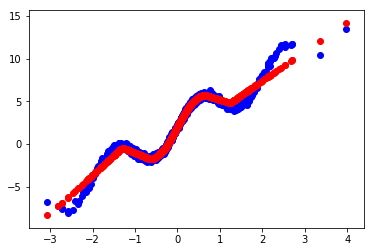

Current loss: 
0.24781765


In [ ]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(tf.expand_dims(inputs,1))[:,0], c='r')
plt.show()

print('Current loss: '),
print(loss(model(tf.expand_dims(inputs,1))[:,0], outputs).numpy())


In [ ]:
#Subclassing
#This is the most flexible method. You ineherit the tf.keras.Model and its functions.
# From great flexibility comes great responsibility!
class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__(name='my_model')
        # Define your layers here.
        self.dense_1 = layers.Dense(64, activation='relu')
        self.dense_2 = layers.Dense(64, activation='relu')
        self.dense_3 = layers.Dense(1, activation='linear')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.dense_3(x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mse'])

In [42]:
model.fit(x = inputs, y = outputs, epochs = 50, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 169us/sample - loss: 0.4499 - mse: 0.4499 - val_loss: 0.2953 - val_mse: 0.2953
Epoch 2/50
900/900 [==============================] - 0s 103us/sample - loss: 0.4232 - mse: 0.4232 - val_loss: 0.2798 - val_mse: 0.2798
Epoch 3/50
900/900 [==============================] - 0s 81us/sample - loss: 0.4027 - mse: 0.4027 - val_loss: 0.2857 - val_mse: 0.2857
Epoch 4/50
900/900 [==============================] - 0s 96us/sample - loss: 0.3909 - mse: 0.3909 - val_loss: 0.2795 - val_mse: 0.2795
Epoch 5/50
900/900 [==============================] - 0s 88us/sample - loss: 0.3744 - mse: 0.3744 - val_loss: 0.2532 - val_mse: 0.2532
Epoch 6/50
900/900 [==============================] - 0s 98us/sample - loss: 0.3651 - mse: 0.3651 - val_loss: 0.2691 - val_mse: 0.2691
Epoch 7/50
900/900 [==============================] - 0s 176us/sample - loss: 0.3501 - mse: 0.3501 - val_loss: 0.2504 - val_mse: 0.2504
Epoch 

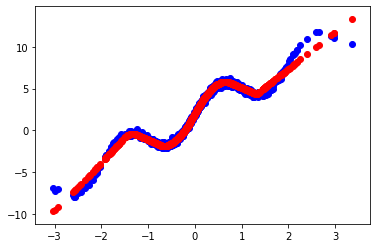

Current loss: 
0.12957716


In [43]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(tf.expand_dims(inputs,1))[:,0], c='r')
plt.show()

print('Current loss: '),
print(loss(model(tf.expand_dims(inputs,1))[:,0], outputs).numpy())


In [44]:
model.save('my_model.h5')
model = tf.keras.models.load_model('my_model.h5')

# The best way to use data: tf.data!
GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build flexible and efficient input pipelines. 
**extract, transform, load!**

In [45]:
#Let's reuse our previous 1 dim dataset.
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs)) #this creates a dataset from something you have in memory 

In [46]:
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs))
for i,x in enumerate(ds): #you can easility iterate over a ds
    print(x)
    if i == 10: 
        break

(<tf.Tensor: id=31287, shape=(), dtype=float32, numpy=-0.010563695>, <tf.Tensor: id=31288, shape=(), dtype=float32, numpy=1.9233837>)
(<tf.Tensor: id=31291, shape=(), dtype=float32, numpy=0.044251975>, <tf.Tensor: id=31292, shape=(), dtype=float32, numpy=2.6727238>)
(<tf.Tensor: id=31295, shape=(), dtype=float32, numpy=-1.4622974>, <tf.Tensor: id=31296, shape=(), dtype=float32, numpy=-0.6156349>)
(<tf.Tensor: id=31299, shape=(), dtype=float32, numpy=-0.57407683>, <tf.Tensor: id=31300, shape=(), dtype=float32, numpy=-1.6733124>)
(<tf.Tensor: id=31303, shape=(), dtype=float32, numpy=1.2069137>, <tf.Tensor: id=31304, shape=(), dtype=float32, numpy=4.44668>)
(<tf.Tensor: id=31307, shape=(), dtype=float32, numpy=1.0341294>, <tf.Tensor: id=31308, shape=(), dtype=float32, numpy=4.851983>)
(<tf.Tensor: id=31311, shape=(), dtype=float32, numpy=1.4742028>, <tf.Tensor: id=31312, shape=(), dtype=float32, numpy=4.5641437>)
(<tf.Tensor: id=31315, shape=(), dtype=float32, numpy=-0.1251066>, <tf.Tenso

In [47]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = ds.shuffle(buffer_size=1000)  #shuffle samples
ds = ds.repeat()  #repeat the dataset as many times as you need
ds = ds.batch(BATCH_SIZE) #create automatic batches
ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.float32, tf.float32)>

In [48]:
for i,x in enumerate(ds): #notice what is returned now
    print(x)
    if i == 10: break

(<tf.Tensor: id=31346, shape=(32,), dtype=float32, numpy=
array([-0.9973567 ,  0.3865311 , -0.18483795,  0.6394464 , -0.24171029,
        1.9505411 ,  0.1485773 , -0.3522076 , -0.11489953,  0.32845455,
        1.0739279 , -0.39084032,  1.0002232 , -0.3645182 , -0.831446  ,
        0.12109703,  0.2564533 , -1.4916905 , -0.35643157, -1.1143177 ,
       -1.0063703 , -0.77015364,  0.03146765, -0.6302217 ,  0.5267651 ,
        0.9783486 , -0.20760643, -1.1028408 ,  0.20181873,  1.4495523 ,
       -0.9995204 ,  1.1774029 ], dtype=float32)>, <tf.Tensor: id=31347, shape=(32,), dtype=float32, numpy=
array([-1.06979   ,  4.8824806 ,  0.49972653,  5.972629  , -0.29657674,
        7.5587645 ,  3.411986  , -0.7405429 ,  0.9173824 ,  4.4038744 ,
        4.4248767 , -0.8256469 ,  5.4304056 , -0.82970846, -1.5341675 ,
        3.347995  ,  3.9000454 , -0.3906362 , -0.46575367, -0.39722347,
       -1.0167717 , -1.8352336 ,  2.258323  , -1.8261878 ,  5.2533073 ,
        5.283815  ,  0.35966623, -0.596269

In [ ]:
#Let's use an image dataset

In [49]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True) #download the dataset of flowers
data_root = pathlib.Path(data_root_orig)

import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)  #store all paths and shuffle them

228818944/228813984 [==============================] - 12s 0us/step


In [50]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] 
                    for path in all_image_paths] #get labels to classify them

def load_and_preprocess_image(path):  #load image using tensorflow function and preprocess it
    image = tf.io.read_file(path)
    return preprocess_image(image)

def preprocess_image(image):  #preprocess by decoding and resizing it
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

In [51]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths) #all the images won't probably fit in memory, but the paths will,
path_ds                                                       # and you can use the same method to create a dataset!

<TensorSliceDataset shapes: (), types: tf.string>

In [52]:
image_ds = path_ds.map(load_and_preprocess_image) #big difference: the map method applied the given function to each sample. Our function also loads the data, going from path to actual image!


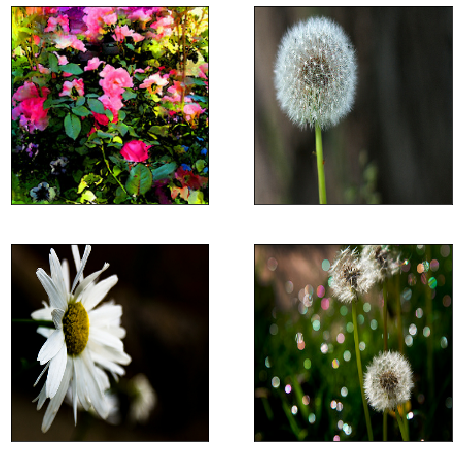

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])


In [54]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))


In [55]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))  #we can create the full X,y dataset by zipping two datasets...


In [56]:
#An alternative!
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels)) #... or creating it with a tuple of arrays!

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [57]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=3000)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(5)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

# The best of both worlds: tf.function and AutoGraph

In [58]:
"""TF 2.0 brings together the ease of eager execution and the power of TF 1.0. At the center of this merger is tf.function, 
which allows you to transform a subset of Python syntax into portable, high-performance TensorFlow graphs."""

from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

In [59]:
def add(a, b):
    return a + b

add(tf.ones([2, 2]), tf.ones([2, 2]))  #  [[2., 2.], [2., 2.]]
add #this is a normal python function

<function __main__.add(a, b)>

In [60]:
@tf.function
def add(a, b):
    return a + b

add(tf.ones([2, 2]), tf.ones([2, 2]))  #  [[2., 2.], [2., 2.]]
add #this is now something else!

In [61]:
def linear_layer(x):
    return 2 * x + 1


@tf.function #if your decorated function has other functions inside, they get automatically compiled
def deep_net(x):
    return tf.nn.relu(linear_layer(x))


deep_net(tf.constant((1, 2, 3)))

<tf.Tensor: id=31484, shape=(3,), dtype=int32, numpy=array([3, 5, 7], dtype=int32)>

In [62]:
@tf.function
def add(a, b):
    return a + b

v = tf.Variable(1.0)
with tf.GradientTape() as tape:  #you can also compute gradients
    result = add(v, 1.0)
tape.gradient(result, v)

<tf.Tensor: id=31510, shape=(), dtype=float32, numpy=1.0>

In [65]:
@tf.function  #control flow like ifs and whiles works like a charm.
def sum_even(items):
    s = 0
    for c in items:
        if c % 2 > 0:
            continue
        s += c
    return s


sum_even(tf.constant([10, 12, 15, 20]))

<tf.Tensor: id=31602, shape=(), dtype=int32, numpy=42>

Autograph basically "compiles" python code to tensorflow code.

In [67]:
print(tf.autograph.to_code(sum_even.python_function, experimental_optional_features=None)) 

def tf__sum_even(items):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  s = 0

  def loop_body(loop_vars, s_2):
    c = loop_vars
    continue_ = False
    cond = c % 2 > 0

    def get_state():
      return ()

    def set_state(_):
      pass

    def if_true():
      continue_ = True
      return continue_

    def if_false():
      return continue_
    continue_ = ag__.if_stmt(cond, if_true, if_false, get_state, set_state)
    cond_1 = ag__.not_(continue_)

    def get_state_1():
      return ()

    def set_state_1(_):
      pass

    def if_true_1():
      s_1, = s_2,
      s_1 += c
      return s_1

    def if_false_1():
      return s_2
    s_2 = ag__.if_stmt(cond_1, if_true_1, if_false_1, get_state_1, set_state_1)
    return s_2,
  s, = ag__.for_stmt(items, None, loop_body, (s,))
  do_return = True
  retval_ = s
  cond_2 = ag__.is_undefined_return(retval_)

  def get_state_2():
    return ()

  def set_state_2(_):
    pass

  def if_true_2():
    retval_ = None


In [68]:
# Functions can be faster than eager code, for graphs with many small ops

import timeit
conv_layer = tf.keras.layers.Conv2D(100, 3)

@tf.function
def conv_fn(image):
    return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])
# warm up
conv_layer(image); conv_fn(image)
print("Eager conv:", timeit.timeit(lambda: conv_layer(image), number=10))
print("Function conv:", timeit.timeit(lambda: conv_fn(image), number=10))
print("Note how there's not much difference in performance for convolutions")

lstm_cell = tf.keras.layers.LSTMCell(10)

@tf.function
def lstm_fn(input, state):
    return lstm_cell(input, state)

input = tf.zeros([10, 10])
state = [tf.zeros([10, 10])] * 2
# warm up
lstm_cell(input, state); lstm_fn(input, state)
print("eager lstm:", timeit.timeit(lambda: lstm_cell(input, state), number=10))
print("function lstm:", timeit.timeit(lambda: lstm_fn(input, state), number=10))

Eager conv: 0.6629254210000113
Function conv: 0.7085221039999965
Note how there's not much difference in performance for convolutions
eager lstm: 0.005691044000002421
function lstm: 0.0046823040000276706


In [69]:
class CustomModel(tf.keras.models.Model):

  @tf.function  #Highly suggested to use it in yours models as well!
  def call(self, input_data):
    if tf.reduce_mean(input_data) > 0:
        return input_data
    else:
        return input_data // 2


model = CustomModel()

model(tf.constant([-2, -4]))

<tf.Tensor: id=32087, shape=(2,), dtype=int32, numpy=array([-1, -2], dtype=int32)>

# A full example: Eager + Keras + GradientTape + Data + Autograph!

In [70]:
from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

In [71]:
def prepare_mnist_features_and_labels(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

def mnist_dataset():
    (x, y), _ = tf.keras.datasets.mnist.load_data()
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    return ds

train_dataset = mnist_dataset()

In [72]:
with tf.device("/device:CPU:0"):
    model = tf.keras.Sequential((
        tf.keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10)))
    model.build()
    optimizer = tf.keras.optimizers.Adam()

In [74]:
with tf.device("/device:CPU:0"):

    compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()


    def train_one_step(model, optimizer, x, y):
        with tf.GradientTape() as tape:
            logits = model(x)
            loss = compute_loss(y, logits)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        compute_accuracy(y, logits)
        return loss


        @tf.function
        def train(model, optimizer):
            train_ds = mnist_dataset()
            step = 0
            loss = 0.0
            accuracy = 0.0
            for x, y in train_ds:
                step += 1
                loss = train_one_step(model, optimizer, x, y)
                if tf.equal(step % 10, 0):
                    tf.print('Step', step, ': loss', loss, '; accuracy', compute_accuracy.result())
            return step, loss, accuracy

            step, loss, accuracy = train(model, optimizer)
            print('Final step', step, ': loss', loss, '; accuracy', compute_accuracy.result())